In [77]:
BATCH_SIZE = 32
EDGE_CROP = 16
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = (1, 1)
# downsampling in preprocessing
IMG_SCALING = (2, 2)
# number of validation images to use
VALID_IMG_COUNT = 600
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 150
AUGMENT_BRIGHTNESS = False

In [78]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util import montage2d as montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

import gc; gc.enable() # memory is tight

from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [79]:
ship_dir = '/home/ubuntu/data/'

In [80]:
train_image_dir = os.path.join(ship_dir, 'train')
test_image_dir = os.path.join(ship_dir, 'test')

In [81]:
masks = pd.read_csv(os.path.join(ship_dir,'train_ship_segmentations.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

131030 masks found
104070


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


,ImageId,ships,has_ship,has_ship_vec,file_size_kb
87829,d82b35bcc.jpg,0,0.0,[0.0],175.200195
41246,657844ff8.jpg,0,0.0,[0.0],124.561523
86331,d4932c9be.jpg,0,0.0,[0.0],211.392578
101140,f8cff2e36.jpg,0,0.0,[0.0],144.389648
15110,24d305f20.jpg,0,0.0,[0.0],118.321289


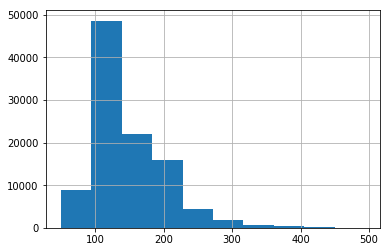

In [82]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)
#print(unique_img_ids['file_size_kb']<50)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50] # keep only 50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

In [83]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.2, #Changed the ratio to 0.2 
                 stratify = unique_img_ids['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

91008 training masks
39006 validation masks


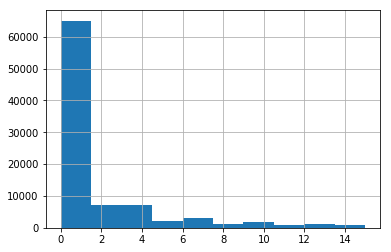

In [84]:
train_df['ships'].hist()

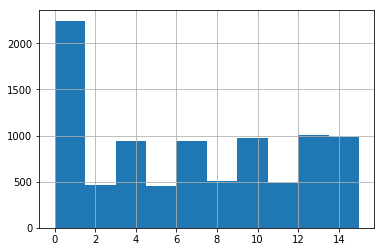

In [85]:
train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x+2)//3)
balanced_train_df = train_df.groupby('grouped_ship_count').apply(lambda x: x.sample(1500))
balanced_train_df['ships'].hist()

In [86]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [87]:
train_gen = make_image_gen(balanced_train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (32, 384, 384, 3) 0.0 1.0
y (32, 384, 384, 1) 0 1


In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
fig.savefig('overview.png')

In [89]:
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(600, 384, 384, 3) (600, 384, 384, 1)


In [90]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.4, 
                  height_shift_range = 0.4, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25], 
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

In [ ]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

In [92]:
gc.collect()


137999

In [93]:
from keras import models, layers

## Double-conv U-net

### Add skip-connections and remove a batch-norm layer

In [94]:
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

ic1 = layers.Conv2D(32, (3, 3),activation=None,padding='same') (pp_in_layer)
b1 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001) (ic1)
#a1 = layers.Activation('relu') (b1)
a1 = layers.ELU()(b1)
c1 = layers.Conv2D(32, (3, 3), activation=None, padding='same') (a1)
#b1 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(c1)
#a1 = layers.Activation('relu') (b1)
ad1 = layers.add([ic1,c1])
a1 = layers.ELU()(ad1)
d1 = layers.Dropout(0.1) (a1)

p1 = layers.MaxPooling2D((2, 2)) (d1)

ic2 = layers.Conv2D(64, (3, 3), activation=None, padding='same') (p1)
b2 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001) (ic2)
#a2 = layers.Activation('relu') (b2)
a2 = layers.ELU()(b2)
c2 = layers.Conv2D(64, (3, 3), activation=None, padding='same') (a2)
#b2 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001) (c2)
#a2 = layers.Activation('relu') (b2)
ad2 = layers.add([ic2,c2])
a2 = layers.ELU()(ad2)
d2 = layers.Dropout(0.1) (a2)

p2 = layers.MaxPooling2D((2, 2)) (d2)


ic3 = layers.Conv2D(128, (3, 3), activation=None, padding='same') (p2)
b3 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001) (ic3)
a3 = layers.ELU()(b3)
#a3 = layers.Activation('relu') (b3)
c3 = layers.Conv2D(128, (3, 3), activation=None, padding='same') (a3)
#b3 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001) (c3)
ad3 = layers.add([ic3,c3])
a3 = layers.ELU()(ad3)
#a3 = layers.Activation('relu') (b3)
d3 = layers.Dropout(0.1) (a3)

p3 = layers.MaxPooling2D((2, 2)) (d3)


ic4 = layers.Conv2D(256, (3, 3), activation=None, padding='same') (p3)
b4 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001) (ic4)
#a4 = layers.Activation('relu') (b4)
a4 = layers.ELU()(b4)
c4 = layers.Conv2D(256, (3, 3), activation=None, padding='same') (a4)
#b4 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001) (c4)
ad4 = layers.add([ic4,c4])
a4 = layers.ELU()(ad4)
#a4 = layers.Activation('relu') (b4)
d4 = layers.Dropout(0.1) (a4)

p4 = layers.MaxPooling2D((2, 2)) (d4)

ic5 = layers.Conv2D(512, (3, 3), activation=None, padding='same') (p4)
b5 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001) (ic5)
a5 = layers.ELU()(b5)
#a5 = layers.Activation('relu') (b5)
c5 = layers.Conv2D(512, (3, 3), activation=None, padding='same') (a5)
#b5 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001) (c5)
ad5 = layers.add([ic5,c5])
a5 = layers.ELU()(ad5)
#a5 = layers.Activation('relu') (b5)
d5 = layers.Dropout(0.1) (a5)
p5 = layers.MaxPool2D((2, 2)) (d5)

ic6 = layers.Conv2D(1024, (3, 3), activation=None, padding='same') (p5)
b6 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001) (ic6)
a6 = layers.ELU()(b6)
#a6 = layers.Activation('relu') (b6)
c6 = layers.Conv2D(1024, (3, 3), activation=None, padding='same') (a6)
#b6 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001) (c6)
ad6 = layers.add([ic6,c6])
a6 = layers.ELU()(ad6)
#a6 = layers.Activation('relu') (b6)
d6 = layers.Dropout(0.1) (a6)

# Decoder starts

# Upsample+concat

u7 = upsample(512, (2, 2), strides=(2, 2), padding='same') (d6)
u7 = layers.concatenate([u7, c5])

# Double-Conv Block
ic7 = layers.Conv2D(512, (3, 3), activation=None, padding='same') (u7)
b7 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001) (ic7)
a7 = layers.ELU()(b7)
#a7 = layers.Activation('relu') (b7)
c7 = layers.Conv2D(512, (3, 3), activation=None, padding='same') (a7)
#b7 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001) (c7)
ad7 = layers.add([ic7,c7])
a7 = layers.ELU()(ad7)
#a7 = layers.Activation('relu') (b7)
d7 = layers.Dropout(0.1) (a7)

u8 = upsample(256, (2, 2), strides=(2, 2), padding='same') (d7)
u8 = layers.concatenate([u8, c4])

ic8 = layers.Conv2D(256, (3, 3), activation=None, padding='same') (u8)
b8 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001) (ic8)
a8 = layers.ELU()(b8)
#a8 = layers.Activation('relu') (b8)
c8 = layers.Conv2D(256, (3, 3), activation=None, padding='same') (a8)
#b8 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001) (c8)
ad8 = layers.add([ic8,c8])
a8 = layers.ELU()(ad8)
#a8 = layers.Activation('relu') (b8)
d8 = layers.Dropout(0.1) (a8)

u9 = upsample(128, (2, 2), strides=(2, 2), padding='same') (d8)
u9 = layers.concatenate([u9, c3])

ic9 = layers.Conv2D(128, (3, 3), activation=None, padding='same') (u9)
b9 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001) (ic9)
a9 = layers.ELU()(b9)
#a9 = layers.Activation('relu') (b9)
c9 = layers.Conv2D(128, (3, 3), activation=None, padding='same') (a9)
#b9 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001) (c9)
ad9 = layers.add([ic9,c9])
a9 = layers.ELU()(ad9)
#a9 = layers.Activation('relu') (b9)
d9 = layers.Dropout(0.1) (a9)


u10 = upsample(64, (2, 2), strides=(2, 2), padding='same') (d9)
u10 = layers.concatenate([u10, c2])

ic10 = layers.Conv2D(64, (3, 3), activation=None, padding='same') (u10)
b10 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001) (ic10)
a10 = layers.ELU()(b10)
#a10 = layers.Activation('relu') (b10)
c10 = layers.Conv2D(64, (3, 3), activation=None, padding='same') (a10)
#b10 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001) (c10)
ad10 = layers.add([ic10,c10])
a10 = layers.ELU()(ad10)
#a10 = layers.Activation('relu') (b10)
d10 = layers.Dropout(0.1) (a10)

u11 = upsample(32, (2, 2), strides=(2, 2), padding='same') (d10)
u11 = layers.concatenate([u11, c1])

ic11 = layers.Conv2D(32, (3, 3),activation=None,padding='same') (u11)
b11 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001) (ic11)
a11 = layers.ELU()(b11)
#a11 = layers.Activation('relu') (b11)
c11 = layers.Conv2D(32, (3, 3), activation=None, padding='same') (a11)
#b11 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(c11)
ad11 = layers.add([ic11,c11])
a11 = layers.ELU()(ad11)
#a11 = layers.Activation('relu') (b11)
d11 = layers.Dropout(0.1) (a11)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (d11)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model = models.Model(inputs=[input_img], outputs=[d])
seg_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
average_pooling2d_4 (AveragePoo (None, 384, 384, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
gaussian_noise_3 (GaussianNoise (None, 384, 384, 3)  0           average_pooling2d_4[0][0]        
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 384, 384, 3)  12          gaussian_noise_3[0][0]           
__________________________________________________________________________________________________
conv2d_47 

In [95]:
from keras.utils import multi_gpu_model
seg_model = multi_gpu_model(seg_model)

In [96]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [98]:
#Change base lr to 0.00001 and step size to 4
clr = CyclicLR(base_lr=0.00001, max_lr=0.006,step_size=2*(balanced_train_df.shape[0]//BATCH_SIZE), mode='exp_range',gamma=0.99994)

In [99]:
import keras.backend as K
from keras.optimizers import Adam,SGD
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
#Value of adam beta_2 reduced from 0.999 to 0.99f or reducing the effect of decreased gradient batches momentum,
# Try reducing the value further to 0.9/0.98 (Xtreme)
#Changed Adam learning rate from 1e-3 to 3e-4
#seg_model.compile(optimizer=Adam(3e-4, decay=1e-6, beta_2=0.99), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])
seg_model.compile(optimizer=SGD(lr=0.0003, momentum=0.9, decay=0.0, nesterov=True), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [100]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model_unet224_reducedlr')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=5, 
                                   verbose=1, mode='max', min_delta=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=20) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [102]:
print(BATCH_SIZE)
step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))
loss_history = [seg_model.fit_generator(aug_gen, 
                             steps_per_epoch=step_count, 
                             epochs=100, 
                             validation_data=(valid_x, valid_y),
                             callbacks=callbacks_list,
                            workers=1 # the generator is not very thread safe
                                       )]

32
Epoch 1/100
150/150 [==============================] - 328s 2s/step - loss: -0.0052 - dice_coef: 0.0058 - binary_accuracy: 0.6822 - true_positive_rate: 0.3985 - val_loss: -0.0034 - val_dice_coef: 0.0038 - val_binary_accuracy: 0.7973 - val_true_positive_rate: 0.2940

Epoch 00001: val_dice_coef improved from -inf to 0.00377, saving model to seg_model_unet224_reducedlr_weights.best.hdf5
Epoch 2/100
150/150 [==============================] - 304s 2s/step - loss: -0.0080 - dice_coef: 0.0085 - binary_accuracy: 0.7492 - true_positive_rate: 0.3969 - val_loss: -0.0062 - val_dice_coef: 0.0064 - val_binary_accuracy: 0.8542 - val_true_positive_rate: 0.1790

Epoch 00002: val_dice_coef improved from 0.00377 to 0.00642, saving model to seg_model_unet224_reducedlr_weights.best.hdf5
Epoch 3/100
150/150 [==============================] - 307s 2s/step - loss: -0.0198 - dice_coef: 0.0203 - binary_accuracy: 0.7830 - true_positive_rate: 0.4343 - val_loss: -0.0207 - val_dice_coef: 0.0209 - val_binary_accu

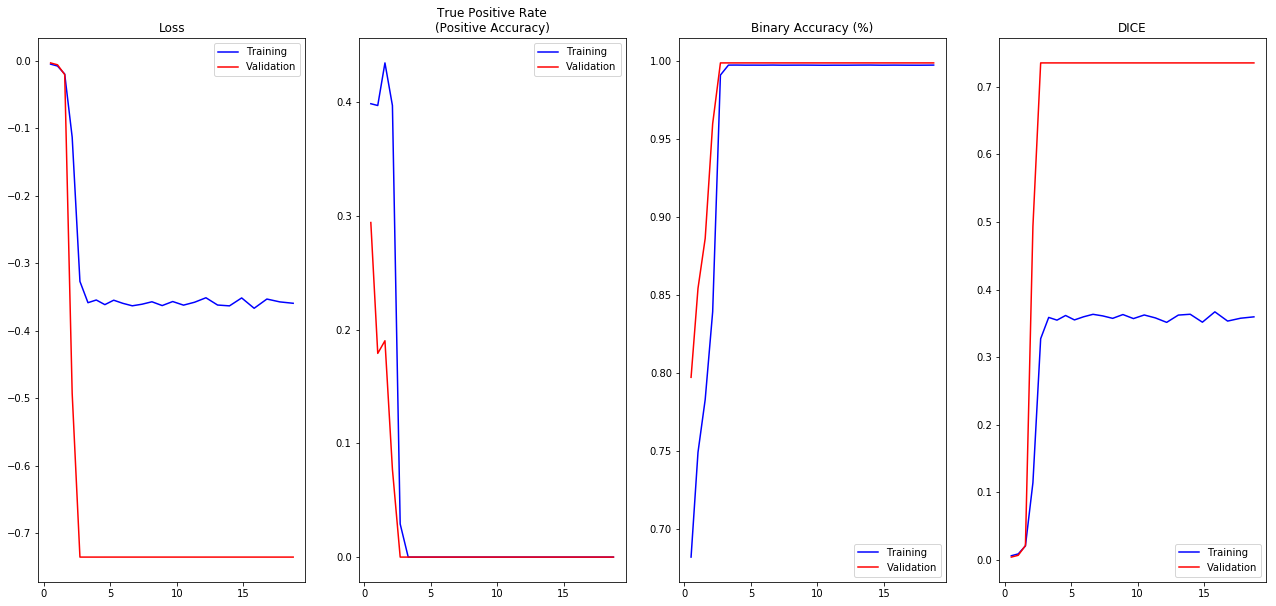

In [103]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

In [104]:
seg_model.load_weights(weight_path)
seg_model.save('seg_model_unet224_reducedlr.h5')

In [105]:
pred_y = seg_model.predict(valid_x)
print(pred_y.shape, pred_y.min(), pred_y.max(), pred_y.mean())

(600, 384, 384, 1) 0.0 1.811696e-05 4.437606e-11


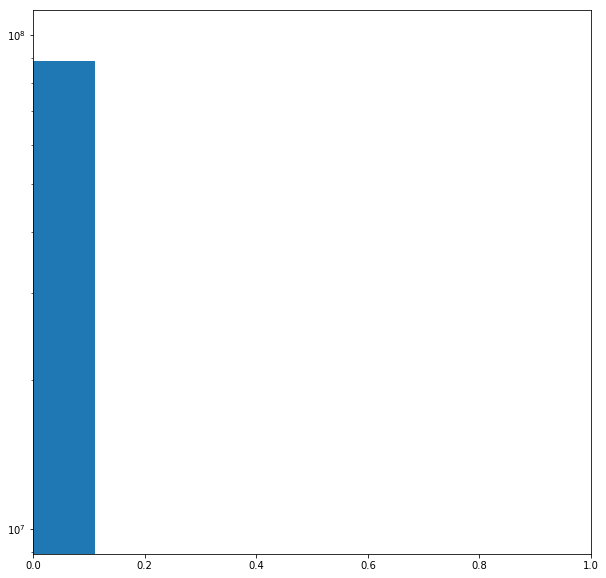

In [106]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 10))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')

In [107]:
if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(seg_model)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = seg_model
fullres_model.save('fullres_model_unet224_reducedlr.h5')

In [108]:
test_paths = os.listdir(test_image_dir)
print(len(test_paths), 'test images found')

88500 test images found


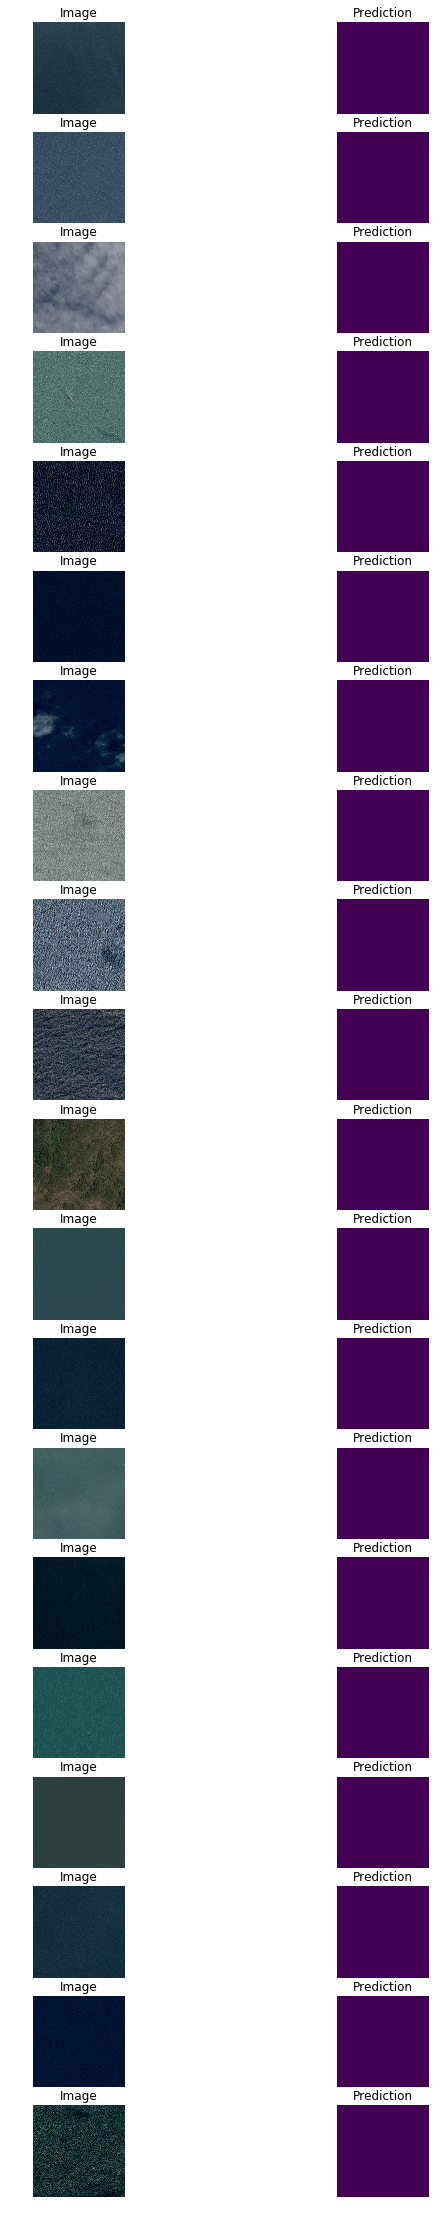

In [109]:
fig, m_axs = plt.subplots(20, 2, figsize = (10, 40))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), c_img_name in zip(m_axs, test_paths):
    c_path = os.path.join(test_image_dir, c_img_name)
    c_img = imread(c_path)
    first_img = np.expand_dims(c_img, 0)/255.0
    first_seg = fullres_model.predict(first_img)
    ax1.imshow(first_img[0])
    ax1.set_title('Image')
    ax2.imshow(first_seg[0, :, :, 0], vmin = 0, vmax = 1)
    ax2.set_title('Prediction')
fig.savefig('test_predictions.png')

## Create Submission

In [ ]:
from tqdm import tqdm_notebook
from skimage.morphology import binary_opening, disk
out_pred_rows = []
for c_img_name in tqdm_notebook(test_paths):
    c_path = os.path.join(test_image_dir, c_img_name)
    c_img = imread(c_path)
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    cur_seg = binary_opening(cur_seg>0.5, np.expand_dims(disk(2), -1))
    cur_rles = multi_rle_encode(cur_seg)
    if len(cur_rles)>0:
        for c_rle in cur_rles:
            out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': c_rle}]
    else:
        out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': None}]
    gc.collect()

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
import pandas as pd
submission_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]
submission_df.to_csv('submission_reducedlr.csv', index=False)
submission_df.sample(3)

In [ ]:
import pandas as pd

sub_df = pd.read_csv('submission_elu_clr_resnet.csv')
#sub_df.drop('13703f040.jpg')
remove = ['13703f040.jpg',
 '14715c06d.jpg',
 '33e0ff2d5.jpg',
 '4d4e09f2a.jpg',
 '877691df8.jpg',
 '8b909bb20.jpg',
 'a8d99130e.jpg',
 'ad55c3143.jpg',
 'c8260c541.jpg',
 'd6c7f17c7.jpg',
 'dc3e7c901.jpg',
 'e44dffe88.jpg',
 'ef87bad36.jpg',
 'f083256d8.jpg']
for i in remove:
    sub_df = sub_df[sub_df.ImageId != i]
sub_df.sample(frac = 0.001)
#sub_df.sample(frac notnull())'14715c06d.jpg'